In [71]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import missingno as mno 
from matplotlib import pyplot as plt 
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score,root_mean_squared_error, make_scorer

### Importer le dataset

In [49]:
df = pd.read_csv('../data/Invistico_Airlines.csv') 

### visualiser les premières lignes du dataset

In [3]:
df.head()

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0


### Analyser les types de données

In [5]:
print(f'il y a {df.select_dtypes(include='number').shape[1]} variables numerique')
print(f'il y a {df.select_dtypes(exclude='number').shape[1]} variables categorielle')

il y a 18 variables numerique
il y a 5 variables categorielle


### Détecter les valeurs manquantes

In [5]:
df.isna().sum()

satisfaction                           0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Seat comfort                           0
Departure/Arrival time convenient      0
Food and drink                         0
Gate location                          0
Inflight wifi service                  0
Inflight entertainment                 0
Online support                         0
Ease of Online booking                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Cleanliness                            0
Online boarding                        0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
dtype: int64

<Axes: >

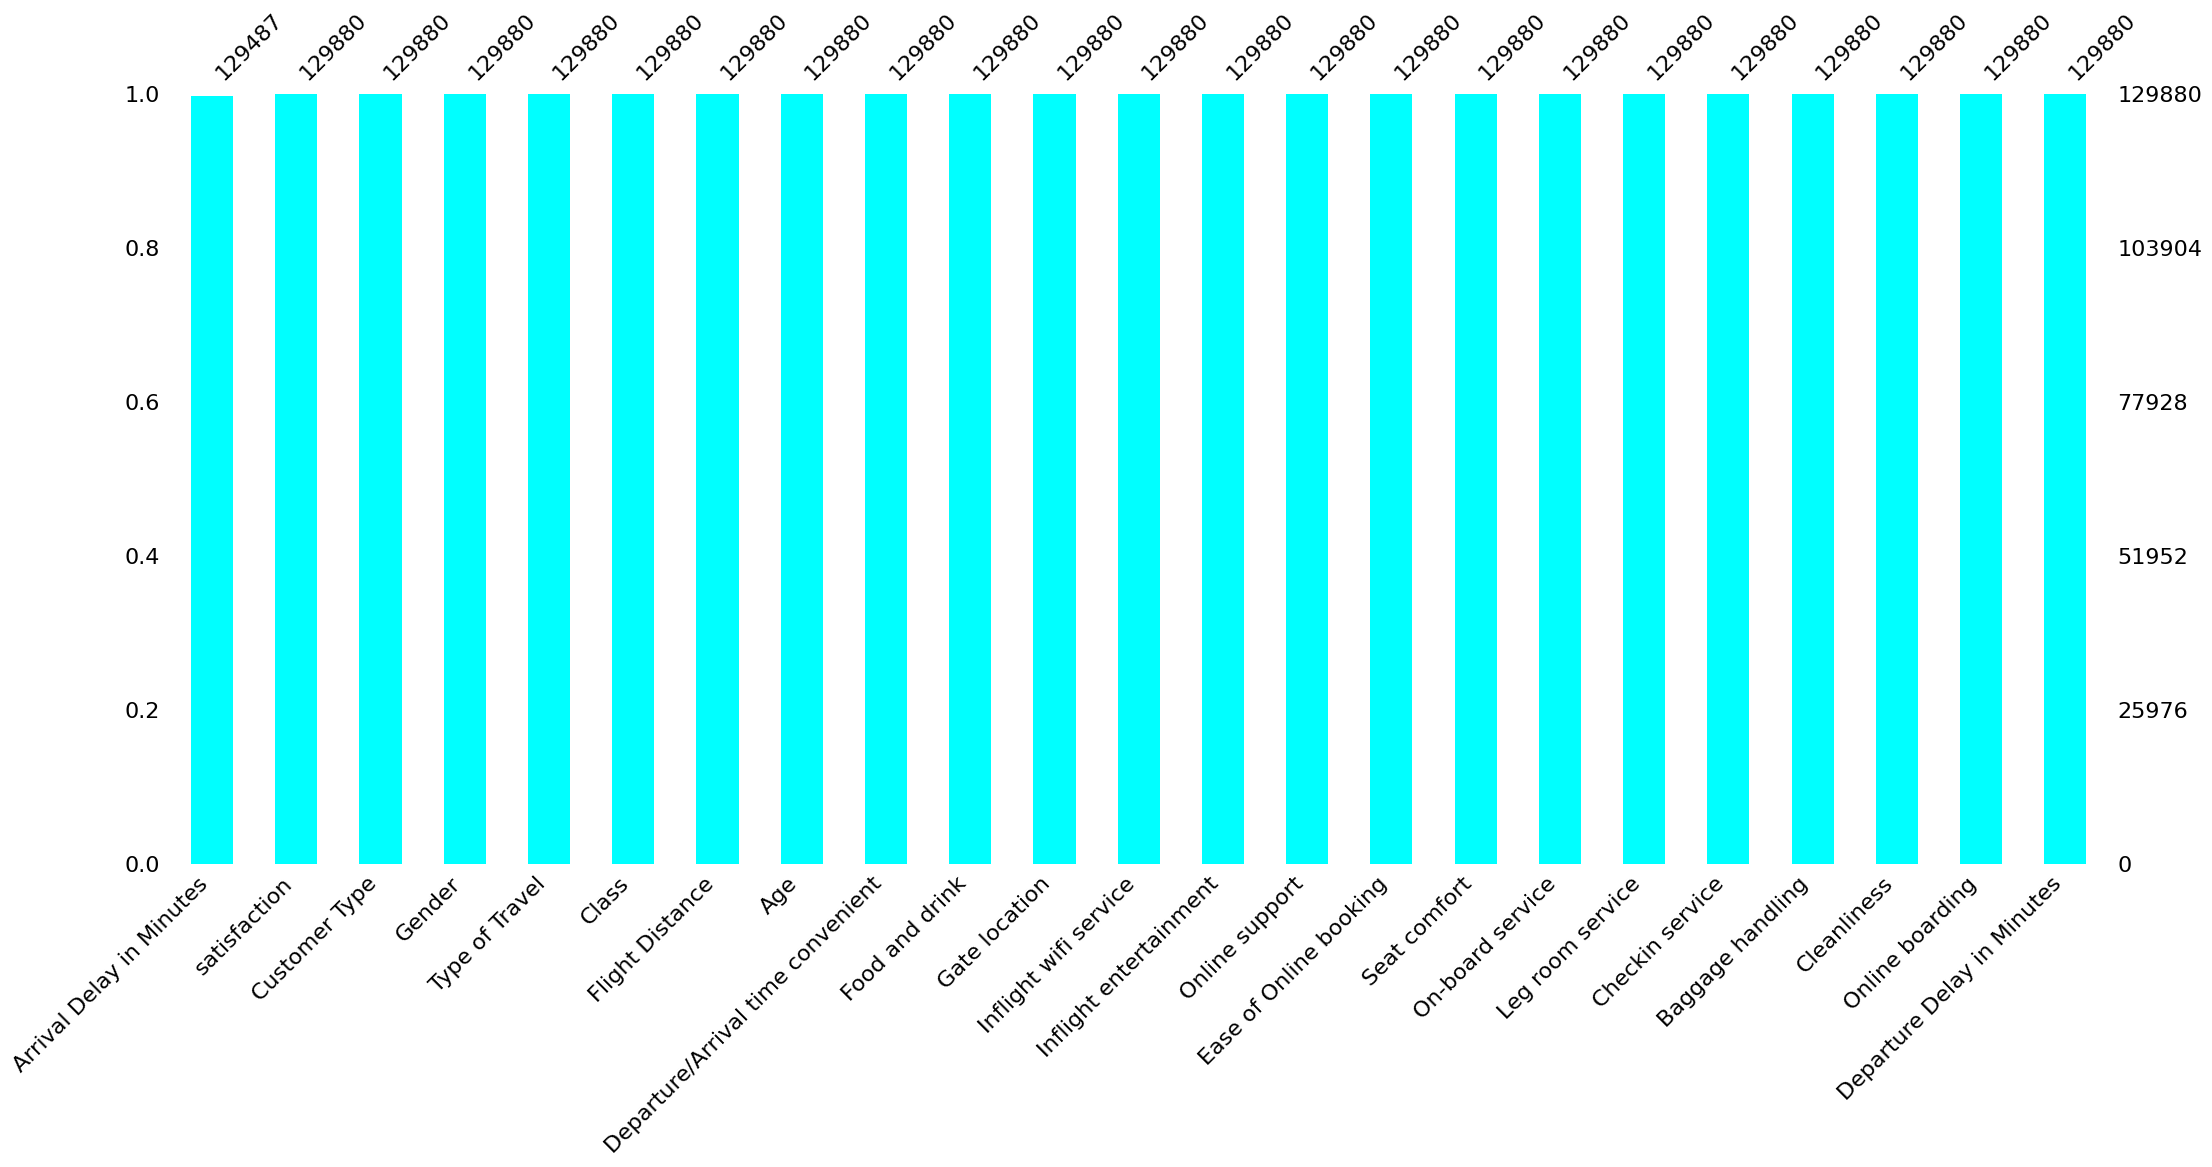

In [37]:
mno.bar(df,sort='ascending',color='aqua')

###  Detecter les valeurs aberrantes

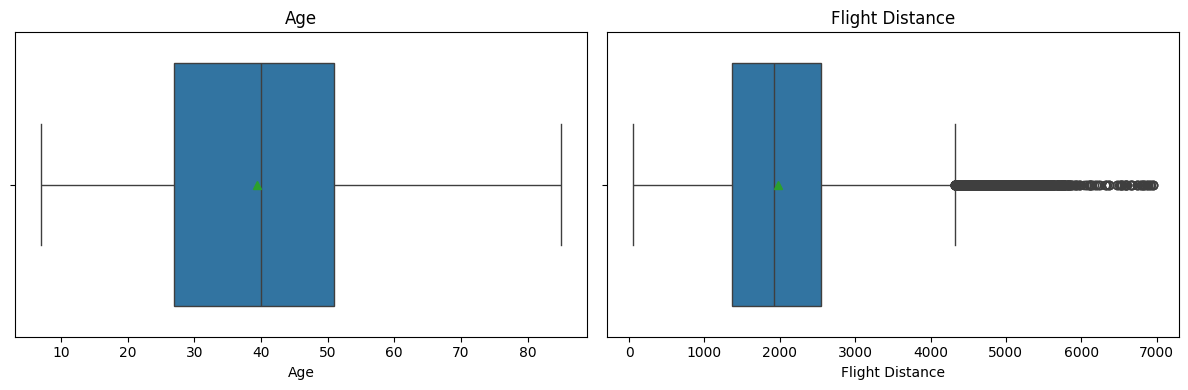

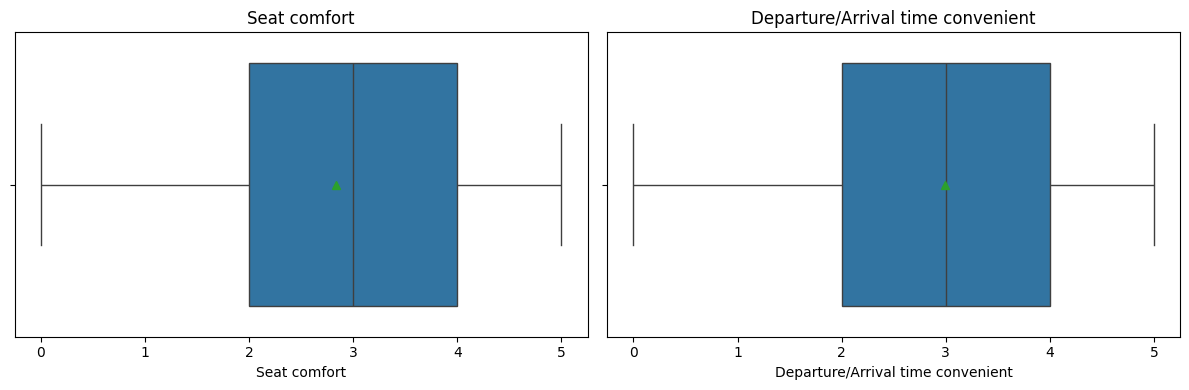

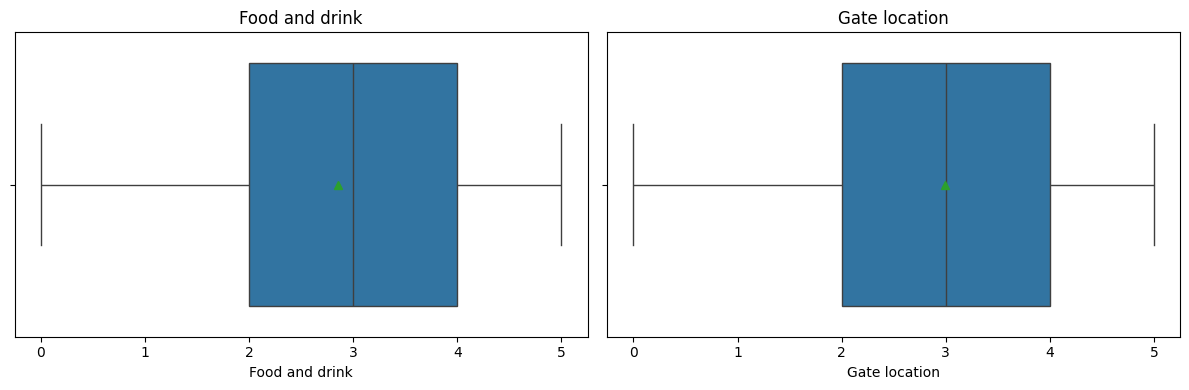

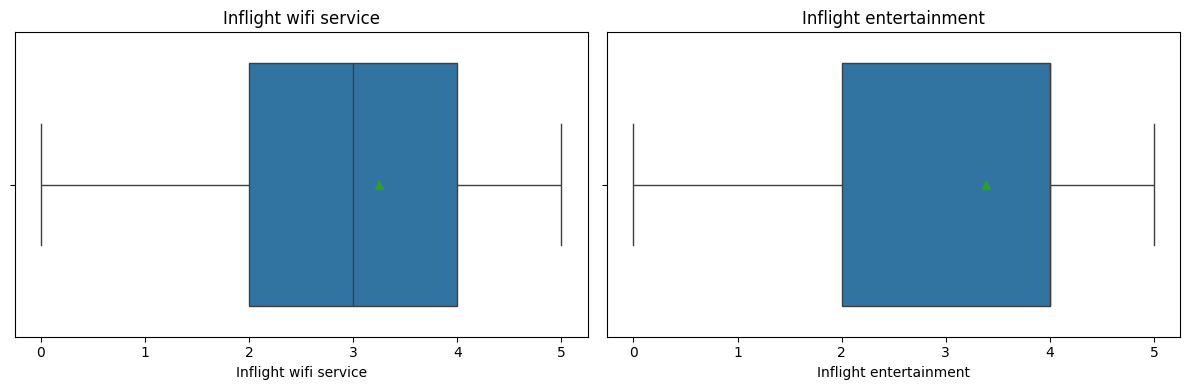

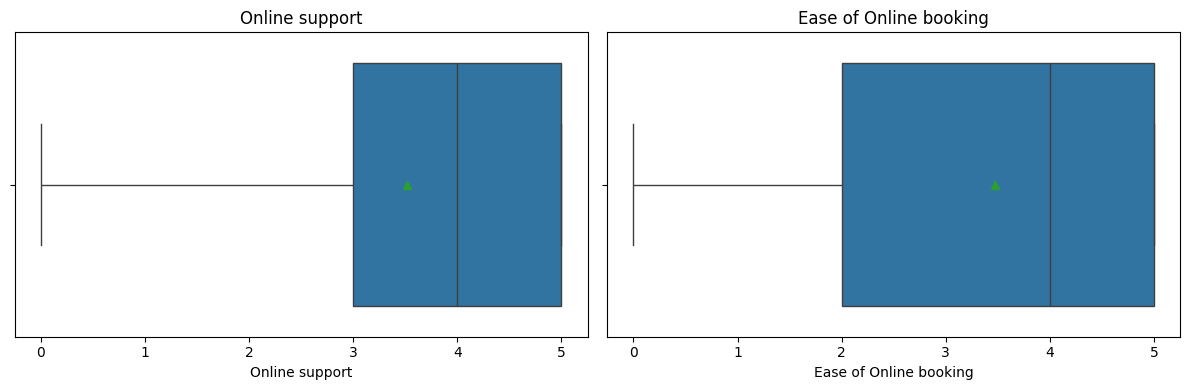

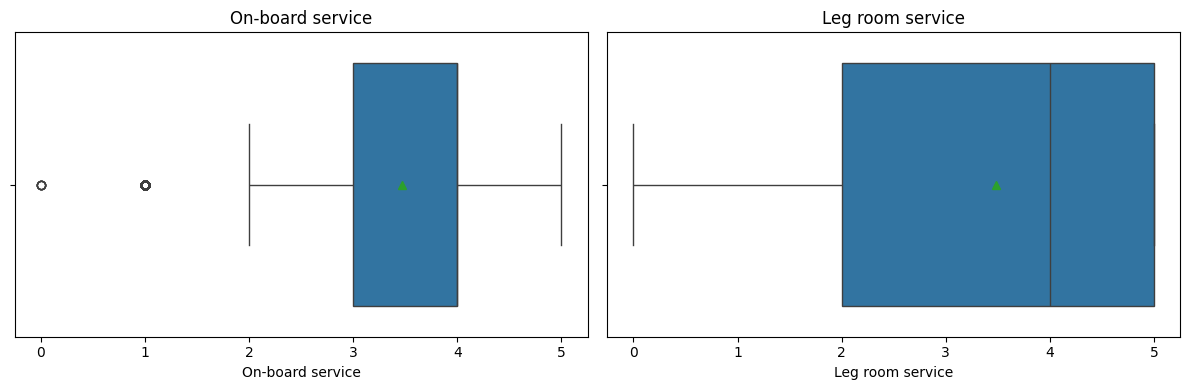

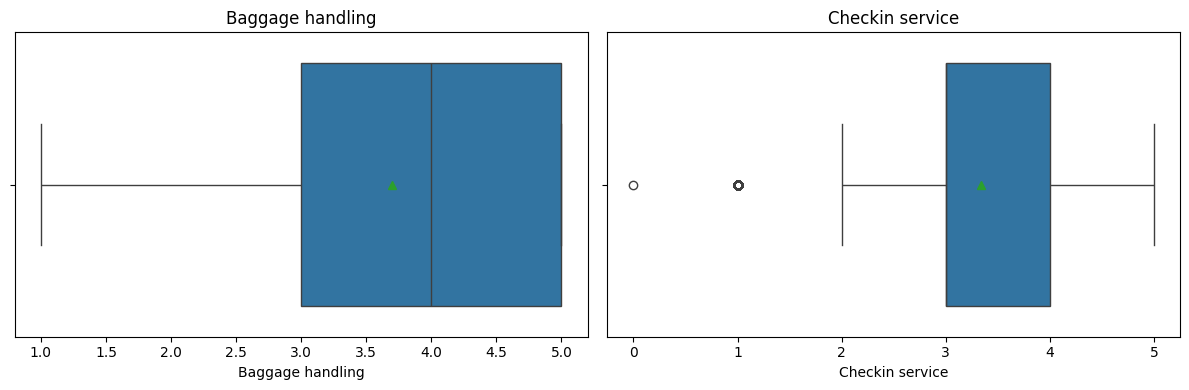

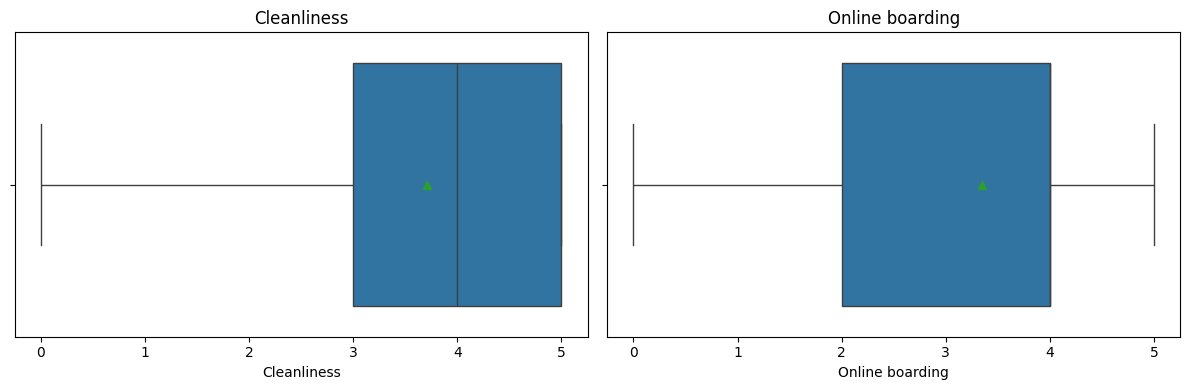

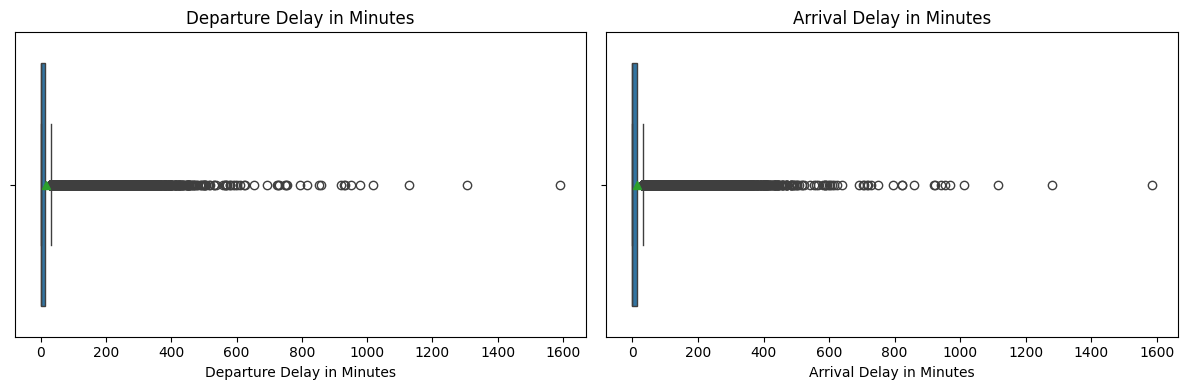

In [ ]:
num_columns = df.select_dtypes('number').columns

for i in range(0, len(num_columns), 2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.boxplot(x=df[num_columns[i]], showmeans=True, ax=axes[0])
    axes[0].set_title(num_columns[i])

    if i + 1 < len(num_columns):
        sns.boxplot(x=df[num_columns[i + 1]], showmeans=True, ax=axes[1])
        axes[1].set_title(num_columns[i + 1])
    else:
        axes[1].axis('off')

    plt.tight_layout()
    plt.show() 

###  identifier les corrélations entre les variables.

In [44]:
def heatmaps(df):
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.corr(numeric_only=True).round(2),
            annot = True, 
            cmap = 'coolwarm', 
            cbar = True, 
            annot_kws = {'fontsize': 10},
            vmin = -1,
            vmax = 1,
            lw = .1,
            mask = np.triu(np.ones_like(df.select_dtypes(['number']).corr()))
        )
    plt.title("Matrice de correlation")
    plt.show()

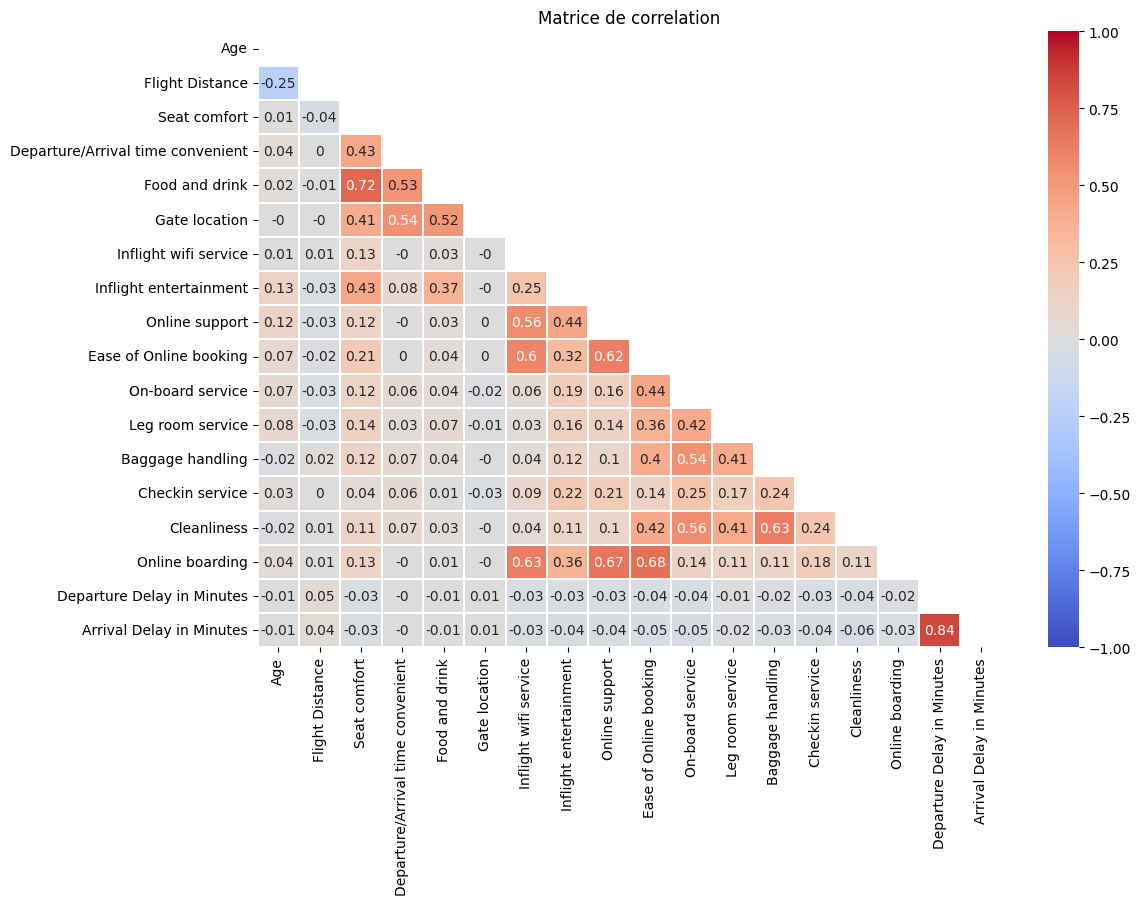

In [45]:
heatmaps(df)

### Visualiser la distribution des données pour les différentes classes

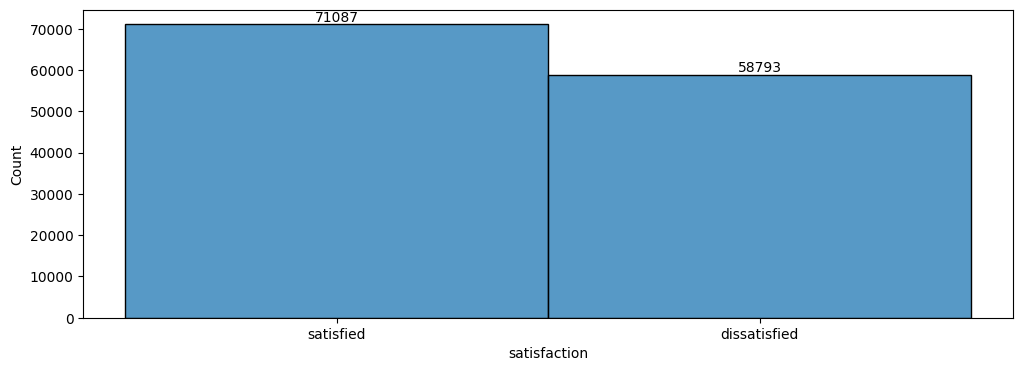

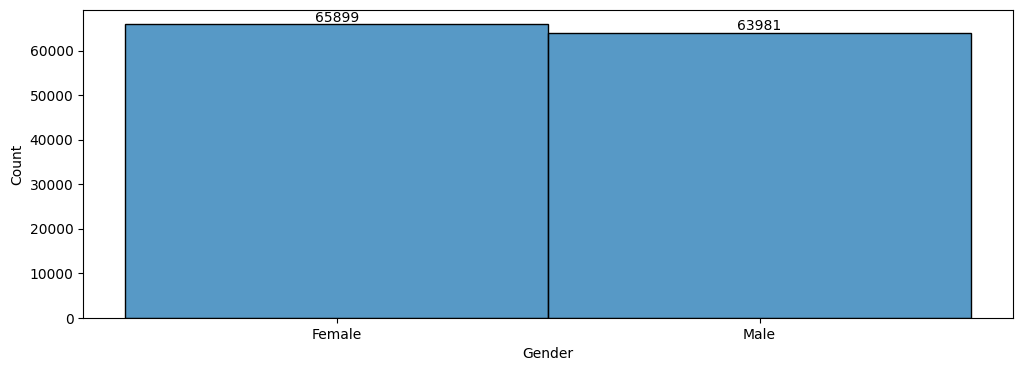

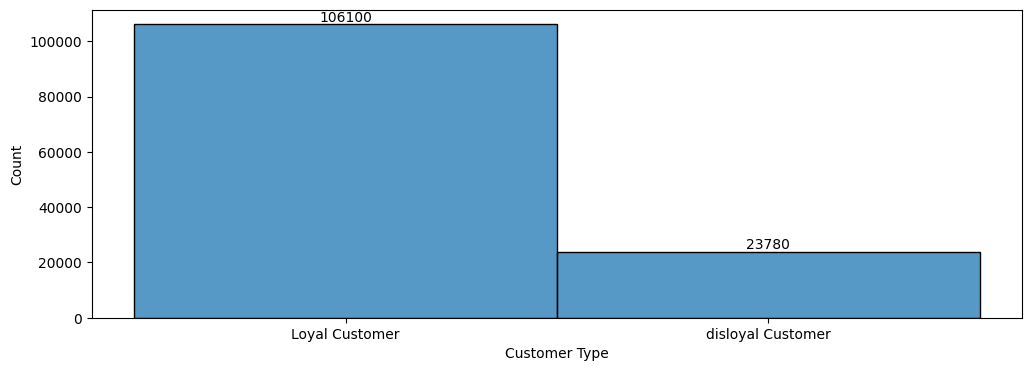

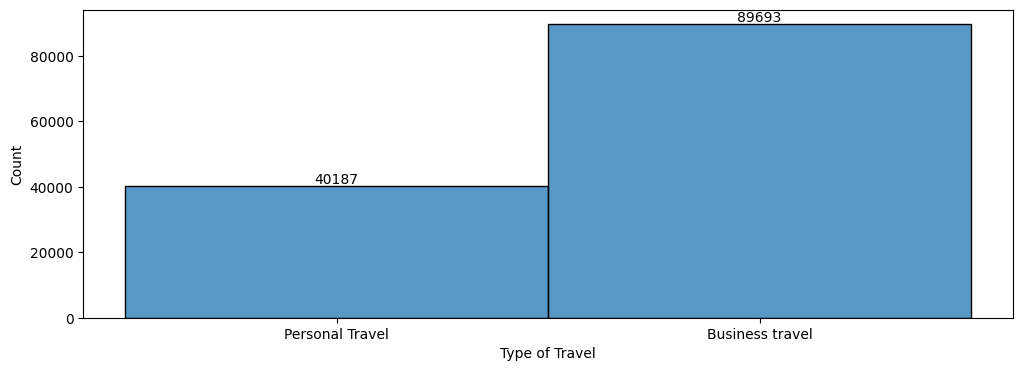

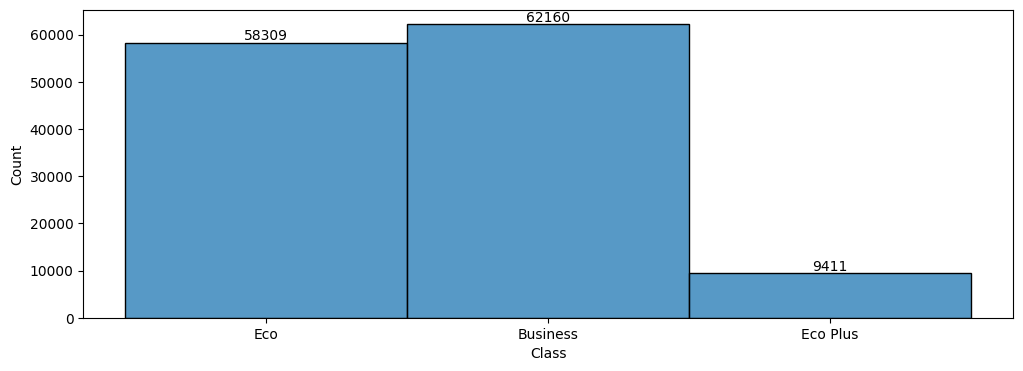

In [13]:
for col in df.select_dtypes(exclude='number').columns:
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,4))
    sns.histplot(x = df[col],data = df)
    for bar in axes.containers: axes.bar_label(bar)
plt.show()

### Gestion de preprocessing

In [ ]:
def preprocess_data(df):
    """
    Prétraitement d'un DataFrame pour la modélisation.

    Cette fonction effectue les étapes suivantes :
    1. Gestion des valeurs aberrantes :
        - Identification des valeurs aberrantes à l'aide de l'intervalle interquartile.
        - Remplacement des valeurs aberrantes par les bornes de l'intervalle.
    2. Transformation des variables numériques :
        - Imputation des valeurs manquantes par la médiane.
        - Standardisation des variables pour une moyenne nulle et une variance unitaire.
    3. Transformation des variables catégorielles :
        - Encodage one-hot pour représenter les catégories sous forme de variables binaires.
    4. Création d'un nouveau DataFrame avec les données prétraitées.

    Args:
        df (pd.DataFrame): DataFrame à prétraiter.

    Returns:
        pd.DataFrame: DataFrame prétraité.
    """
    def impute_outliers(data, colname):
        q1 = np.percentile(data[colname].dropna(), 25)
        q3 = np.percentile(data[colname].dropna(), 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr 
        upper_bound = q3 + 1.5 * iqr

        data[colname] = np.where(data[colname] < lower_bound, lower_bound, data[colname])
        data[colname] = np.where(data[colname] > upper_bound, upper_bound, data[colname])

    for col in df.select_dtypes(include="number").columns:
        impute_outliers(df, col)

    numeric_features = df.select_dtypes(include="number").columns
    categorical_features = df.select_dtypes(exclude="number").columns

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), 
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('encoder', OneHotEncoder(handle_unknown='ignore')) 
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    df_transformed = preprocessor.fit_transform(df)

    columns = numeric_features.tolist() + list(preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features))
    df_preprocessed = pd.DataFrame(df_transformed, columns=columns)

    if 'satisfaction_satisfied' in df_preprocessed.columns and 'satisfaction_dissatisfied' in df_preprocessed.columns:
        df_preprocessed['satisfaction'] = np.where(df_preprocessed['satisfaction_satisfied'] == 1, 1.0, 0.0)
        df_preprocessed.drop(columns=['satisfaction_satisfied', 'satisfaction_dissatisfied'], inplace=True)

    return df_preprocessed 

In [53]:
df_clean = preprocess_data(df)

### Réduction de Dimensionnalité avec l’ACP

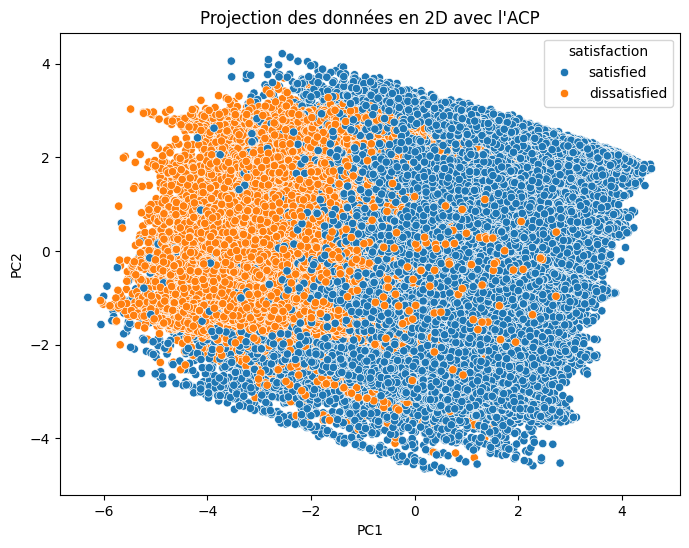

Variance expliquée par composant :
[0.2023817  0.12701487]

Variables influençant le plus PC1 :
Ease of Online booking    0.411840
Online support            0.333654
Online boarding           0.331935
Inflight entertainment    0.292865
On-board service          0.287584
Name: PC1, dtype: float64

Variables influençant le plus PC2 :
Food and drink                       0.521117
Departure/Arrival time convenient    0.458199
Gate location                        0.457304
Seat comfort                         0.441856
Ease of Online booking               0.150617
Name: PC2, dtype: float64


In [54]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_clean)

df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue=df['satisfaction'], data=df_pca)
plt.title("Projection des données en 2D avec l'ACP")
plt.show()

print("Variance expliquée par composant :")
print(pca.explained_variance_ratio_)

loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=df_clean.columns)

top_influencers_pc1 = loadings['PC1'].abs().sort_values(ascending=False).head()
top_influencers_pc2 = loadings['PC2'].abs().sort_values(ascending=False).head()

print("\nVariables influençant le plus PC1 :")
print(top_influencers_pc1)
print("\nVariables influençant le plus PC2 :")
print(top_influencers_pc2)

### Modélisation et Prédiction

In [57]:
X = df_clean.drop(columns=['satisfaction'])  
y = df_clean['satisfaction']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = root_mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print("Erreur quadratique moyenne (Régression Linéaire) :", mse_lr)
print("Racine carre d'erreur quadratique moyenne (Régression Linéaire) :", rmse_lr)
print("Coefficient de determination (Régression Linéaire) :", r2_lr)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

def evaluate_classification(y_true, y_pred, model_name):
    print(f"\nÉvaluation des performances pour {model_name}:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Précision (precision):", precision_score(y_true, y_pred))
    print("Rappel:", recall_score(y_true, y_pred))
    print("F1-Score:", f1_score(y_true, y_pred))

evaluate_classification(y_test, y_pred_knn, "K-Nearest Neighbors")

evaluate_classification(y_test, y_pred_nb, "Naïve Bayes")


Erreur quadratique moyenne (Régression Linéaire) : 0.12714630826931386
Racine carre d'erreur quadratique moyenne (Régression Linéaire) : 0.3565758099890034
Coefficient de determination (Régression Linéaire) : 0.48712374319923857

Évaluation des performances pour K-Nearest Neighbors:
Accuracy: 0.9225438866646135
Précision (precision): 0.942584776597293
Rappel: 0.9137274266365688
F1-Score: 0.9279318002722258

Évaluation des performances pour Naïve Bayes:
Accuracy: 0.8242608561749307
Précision (precision): 0.8429805153093998
Rappel: 0.8331687358916479
F1-Score: 0.8380459076879413


###  Évaluation et Optimisation des Modèles

In [60]:
cv_scores_knn_accuracy = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_knn_f1 = cross_val_score(knn, X_train, y_train, cv=5, scoring='f1')
cv_scores_knn_recall = cross_val_score(knn, X_train, y_train, cv=5, scoring='recall')
cv_scores_knn_precision = cross_val_score(knn, X_train, y_train, cv=5, scoring='precision')
print("F1-Score moyen avec validation croisée (KNN, avant optimisation) :", cv_scores_knn_accuracy.mean())
print("F1-Score moyen avec validation croisée (KNN, avant optimisation) :", cv_scores_knn_f1.mean())
print("F1-Score moyen avec validation croisée (KNN, avant optimisation) :", cv_scores_knn_recall.mean())
print("F1-Score moyen avec validation croisée (KNN, avant optimisation) :", cv_scores_knn_precision.mean())

cv_scores_nb = cross_val_score(nb, X_train, y_train, cv=5)
print("F1-Score moyen avec validation croisée (Naïve Bayes) :", cv_scores_nb.mean())

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],  
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan']  
}

F1-Score moyen avec validation croisée (KNN, avant optimisation) : 0.9201185501174329
F1-Score moyen avec validation croisée (KNN, avant optimisation) : 0.9258246691218519
F1-Score moyen avec validation croisée (KNN, avant optimisation) : 0.9101755673873801
F1-Score moyen avec validation croisée (KNN, avant optimisation) : 0.9420232601144439
F1-Score moyen avec validation croisée (Naïve Bayes) : 0.8242704941801293


In [ ]:
ridge = Ridge(alpha=0.01)

In [66]:
ridge.fit(X_train, y_train)

Ridge(alpha=0.01)

In [67]:
y_pred = ridge.predict(X_test)

In [69]:
r2 = r2_score(y_test, y_pred)
r2

0.48711606144590647

In [72]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

0.48698781259852053

In [62]:
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5)

In [ ]:
grid_search_knn.fit(X_train, y_train)

In [23]:
best_knn = grid_search_knn.best_estimator_ 
cv_scores_knn_optimized = cross_val_score(best_knn, X, y, cv=5, scoring=make_scorer(f1_score))
print("F1-Score moyen avec validation croisée (KNN, après optimisation) :", cv_scores_knn_optimized)          

F1-Score moyen avec validation croisée (KNN, après optimisation) : [0.8406633  0.52521797 0.83386322 0.89029646 0.77605576]
